In [ ]:
from dataclasses import dataclass, field
import torch 
import os
import sys
import pickle
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from PIL import Image

sys.path.append("../")

from RandAR.utils import instantiate_from_config
from RandAR.utils.inpainting import generate_inpainting
from RandAR.model.nlcd_tokenizer import NLCDTokenizer

parent_path = Path.cwd().parent

@dataclass
class Config:
    config_path: Path = parent_path / "configs/randar_nlcd_32.yaml"  
    gpt_ckpt: Path = parent_path / "results_nlcd_32/randar_nlcd_32/checkpoints/final"
    data_path: Path = parent_path / "data/data_32.npz"
    device: str = "cuda"
    output_path: Path = parent_path / "results/visualizations/wide_animation-2048.gif"
    seed = 827
    # Inference parameters
    cfg_scale: float = 1.0
    temperature: float = 1.0
    top_k: int = 0
    top_p: float = 1.0
    save_path: Path = parent_path / "data/wide_sample.pkl"
    image_width: int = 1024
    fps: int = 30
    vocab_size: int = 16

'''
0: Open Water
1: Perennial Ice/Snow  
2: Developed, Open Space
3: Developed, Low Intensity
4: Developed, Medium Intensity
5: Developed, High Intensity
6: Barren Land (Rock/Sand/Clay)
7: Deciduous Forest
8: Evergreen Forest
9: Mixed Forest
10: Dwarf Scrub
11: Shrub/Scrub
12: Grassland/Herbaceous
13: Sedge/Herbaceous
14: Lichens
15: Moss
'''

config = Config()

np.random.seed(config.seed)
torch.manual_seed(config.seed)

print(f"Loading config from {config.config_path}")
model_config = OmegaConf.load(config.config_path)

print(f"Loading model from {config.gpt_ckpt}")
model = instantiate_from_config(model_config.ar_model)
model = model.to(config.device)
model.eval()

from safetensors.torch import load_file
state_dict = load_file(os.path.join(config.gpt_ckpt, "model.safetensors"))
model.load_state_dict(state_dict)

### Select initial starting image

In [ ]:
data = np.load(config.data_path)['test_data'][:, 0]
start_data_point = data[100].squeeze()
print(f"Picked off initial starting point with shape {start_data_point.shape}")

Picked off initial starting point with shape (32, 32)


### Generate pixels using model

Overlapping a region of width 24 per generation
Running inference for window at coordinates (0, 32)
Running inference for window at coordinates (8, 40)
Running inference for window at coordinates (16, 48)
Running inference for window at coordinates (24, 56)
Running inference for window at coordinates (32, 64)
Running inference for window at coordinates (40, 72)
Running inference for window at coordinates (48, 80)
Running inference for window at coordinates (56, 88)
Running inference for window at coordinates (64, 96)
Running inference for window at coordinates (72, 104)
Running inference for window at coordinates (80, 112)
Running inference for window at coordinates (88, 120)
Running inference for window at coordinates (96, 128)
Running inference for window at coordinates (104, 136)
Running inference for window at coordinates (112, 144)
Running inference for window at coordinates (120, 152)
Running inference for window at coordinates (128, 160)
Running inference for window at coordinat

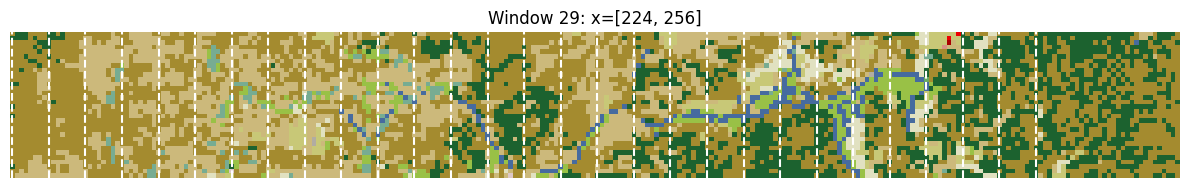

Generated panoramic image of size 32x256


In [ ]:
def nlcd_to_rgb(data):
    """Convert NLCD data values to RGB image using the colormap."""
    vocab_size = int(data.max()) + 1
    return NLCDTokenizer(vocab_size=vocab_size).nlcd_to_rgb(data)

def run_window_inpainting(model, current_window, known_positions, unknown_positions, config, temperature=1.0, logit_bias=None):
    """
    Run inpainting on a window using the model.
    
    Args:
        model: The trained RandAR model
        current_window: Current window data (height x window_size)
        known_positions: 1D array of positions that are known (left half)
        unknown_positions: 1D array of positions to generate (right half)
        config: Configuration object with inference parameters
    
    Returns:
        Generated window with inpainted values
    """
    # Flatten the current window to get known tokens
    window_flat = current_window.flatten()
    known_tokens = window_flat[known_positions]
    
    # Convert to tensors
    cond = torch.tensor([0], dtype=torch.long, device=config.device)  # Dummy class
    known_positions_tensor = torch.tensor(known_positions, dtype=torch.long)
    known_tokens_tensor = torch.tensor(known_tokens, dtype=torch.long)
    unknown_positions_tensor = torch.tensor(unknown_positions, dtype=torch.long)
    
    # Generate inpainted tokens
    with torch.no_grad():
        gen_indices = generate_inpainting(
            model=model,
            cond=cond,
            known_tokens=known_tokens_tensor,
            known_positions=known_positions_tensor,
            unknown_positions=unknown_positions_tensor,
            cfg_scales=(config.cfg_scale, config.cfg_scale),
            temperature=temperature,
            top_k=config.top_k,
            top_p=config.top_p,
            logit_bias=logit_bias,
        )
    
    # Create the output window
    gen_indices_np = gen_indices[0].cpu().numpy()
    output_window = current_window.copy()
    
    # Fill in generated pixels
    for pos in unknown_positions:
        row, col = pos // current_window.shape[1], pos % current_window.shape[1]
        output_window[row, col] = gen_indices_np[pos]
    
    return output_window

# Set up dimensions
height = 32
window_size = 32
overlap =  3 * window_size // 4
print(f"Overlapping a region of width {overlap} per generation")

# Initialize arrays
full_image = np.zeros((height, config.image_width), dtype=np.uint8)

# Create position arrays for model input
token_positions_2d = np.arange(window_size * window_size).reshape(window_size, window_size)
known_token_positions = token_positions_2d[:, :overlap].flatten()
unknown_token_positions = token_positions_2d[:, overlap:].flatten()


# Define x overlaps for sliding window
x_overlaps           = np.arange(0, config.image_width - window_size + 1, window_size - overlap)
temperature_schedule = np.asarray([1.0, 1.1, 1.15, 1.1] * len(x_overlaps))[0:len(x_overlaps)]
logit_bias = np.zeros((config.vocab_size,))
logit_bias[2:6] = -1.0
logit_bias = torch.tensor(logit_bias, dtype=torch.float32, device=config.device)

full_image[:, :window_size] = start_data_point
current_window = full_image[:, :window_size]

# Store frames for animation
frames = []

plt.figure(figsize=(12, 4 * len(x_overlaps)))

for i, (xoff, temp) in enumerate(zip(x_overlaps, temperature_schedule)):
    print(f"Running inference for window at coordinates ({xoff}, {xoff + window_size})")
    
    current_window = full_image[:, xoff:xoff + window_size]
    
    # Run model inference
    sampled_window = run_window_inpainting(
        model, 
        current_window, 
        known_token_positions, 
        unknown_token_positions, 
        config,
        temperature=temp,
        logit_bias=logit_bias
    )
    
    # Update full image
    full_image[:, xoff:xoff + window_size] = sampled_window
    
    # # Visualize
    # ax = plt.subplot(len(x_overlaps), 1, i + 1)
    # ax.imshow(nlcd_to_rgb(full_image), interpolation='nearest')
    # ax.set_title(f"Window {i+1}: x=[{xoff}, {xoff + window_size}]")
    # ax.axis('off')
    
    # # Store frame for animation
    # frames.append(nlcd_to_rgb(full_image[:, :xoff + window_size]))


ax = plt.subplot(len(x_overlaps), 1, i + 1)
ax.imshow(nlcd_to_rgb(full_image), interpolation='nearest')
ax.set_title(f"Window {i+1}: x=[{xoff}, {xoff + window_size}]")
ax.axis('off')

# Put vlines at each of the window boundaries
for xoff in x_overlaps:
    plt.axvline(x=xoff, color='w', linestyle='--')

plt.tight_layout()
plt.show()

print(f"Generated panoramic image of size {height}x{config.image_width}")

with open(config.save_path, 'wb') as f:
    pickle.dump(full_image, f)

### Animation with pixel reveal effect (black to live)

In [ ]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import matplotlib.pyplot as plt

# Create sliding window animation with pixel reveal effect
window_height = 32
window_width = window_height * 4

# Create extended image with mirror reflection for seamless looping
extended_image = np.concatenate([full_image, np.fliplr(full_image), full_image], axis=1)
total_frames = 2 * config.image_width

# Initialize live pixel tracking array (same size as extended image)
# 0 = not yet revealed (black), 1 = live (visible)
live_pixels = np.zeros((window_height, extended_image.shape[1]), dtype=bool)

# Pre-activate pixels in the leftmost part (they're already on screen at start)
live_pixels[:, :window_width] = True

# Create figure for animation
fig, ax = plt.subplots(figsize=(window_width/10, window_height/10))
ax.axis('off')
fig.patch.set_visible(False)
ax.set_position([0, 0, 1, 1])

# Function to activate pixels based on distance from right edge
def activate_pixels(live_pixels, x_start, x_end, frame_num):
    """
    Activate pixels probabilistically based on distance from right edge.
    Pixels should be fully active by the time they reach 3/4 of the window from the right.
    """
    window_live = live_pixels[:, x_start:x_end].copy()
    
    # For each column in the window
    for col_idx in range(window_width):
        # Distance from right edge of window (0 at right, window_width at left)
        dist_from_right = window_width - col_idx
        
        # Pixels in rightmost quarter should activate progressively
        if dist_from_right <= window_width // 4:
            # Probability increases from 0 at right edge to 1 at 3/4 point
            activation_prob = np.exp((window_width // 4 - dist_from_right) / (window_width // 4) / 50)
            activation_prob = min(1.0, activation_prob / 8)  # Speed up activation
            
            # For pixels not yet live, randomly activate based on probability
            for row_idx in range(window_height):
                if not window_live[row_idx, col_idx]:
                    if np.random.random() < activation_prob:
                        window_live[row_idx, col_idx] = True
        else:
            # All pixels past the rightmost quarter should be live
            window_live[:, col_idx] = True
    
    return window_live

# Function to update frame
def update_frame(frame_num):
    ax.clear()
    ax.axis('off')
    
    # Get the window slice from extended image
    x_start = frame_num
    x_end = x_start + window_width
    window = extended_image[:window_height, x_start:x_end].copy()
    
    # Update live pixels for this window
    window_live = activate_pixels(live_pixels, x_start, x_end, frame_num)
    
    # Update the global live pixels array with any newly activated pixels
    live_pixels[:, x_start:x_end] = np.logical_or(live_pixels[:, x_start:x_end], window_live)
    
    # Apply the live mask - pixels that aren't live are black
    masked_window = window.copy()
    masked_window[~window_live] = 0  # Set non-live pixels to black (water)
    
    # Convert to RGB and display
    rgb_window = nlcd_to_rgb(masked_window)

    rgb_window[~window_live] = (0, 0, 0)
    ax.imshow(rgb_window, interpolation='nearest')
    ax.set_xlim(0, window_width)
    ax.set_ylim(window_height, 0)
    ax.set_position([0, 0, 1, 1])
    
    return ax,

# Create animation
anim = animation.FuncAnimation(
    fig, 
    update_frame, 
    frames=total_frames,
    interval=1000/config.fps,
    blit=False
)

# Save animation
output_dir = Path("results/visualizations")
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / "wide-animation-reveal.gif"
writer = PillowWriter(fps=config.fps)
anim.save(
    output_path, 
    writer=writer,
    savefig_kwargs={
        'bbox_inches': 'tight',
        'pad_inches': 0,
        'transparent': True,
        'facecolor': 'none'
    }
)

print(f"Animation with reveal effect saved to {output_path}")
print(f"Total frames: {total_frames}")
print(f"Duration: {total_frames/config.fps:.1f} seconds at {config.fps} fps")

plt.close(fig)

Animation with reveal effect saved to results/visualizations/wide-animation-reveal.gif
Total frames: 384
Duration: 12.8 seconds at 30 fps
